# Epirob 2017

Work in progress. This notebook is the code for replicating the experiments outlined in:

**Developing Grounded Goals through Instant Replay Learning** by Lisa Meeden and Douglas Blank.

https://repository.brynmawr.edu/compsci_pubs/66/

## Generate Data

In [1]:
from jyro.simulator import (Physics, Pioneer, Pioneer16Sonars, PioneerFrontLightSensors, Canvas)
from random import choice
import numpy as np
import os
import conx as cx 
import matplotlib
import matplotlib.pyplot as plt
import pickle
import math

Using TensorFlow backend.
Conx, version 3.6.1


In [2]:
def make_sim():
    """Make the simulated world with a light centered at the bottom"""
    sim = Physics()
    sim.addBox(0, 0, 4, 4, fill="backgroundgreen", wallcolor="gray")
    sim.addLight(2, 0.75, 1.0) # increased brightness for new linear version of lights
    sim.addRobot(Pioneer("RedPioneer", 2, 2, 0.86))
    sim.robots[0].addDevice(Pioneer16Sonars())
    light_sensors = PioneerFrontLightSensors(3.0) # Max range of light sensors
    light_sensors.lightMode = 'ambient'
    sim.robots[0].addDevice(light_sensors)
    return sim

def read_sensors(sim):
    """Return the robot's current sensor readings"""
    robot = sim.robots[0]
    sonars = robot.device['sonar'].scan
    scaled_sonars = [min(s/5.5, 1) for s in sonars]
    lights = robot.device['light'].scan
    stall = [robot.stall]
    return stall + lights + scaled_sonars

def random_action():
    """Generate a random action from a limited set of possible settings"""
    possible = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return [choice(possible), choice(possible)]

def write_list(fp, list):
    """Write a list to a file"""
    for item in list:
        fp.write(str(item))
        fp.write(" ")
    fp.write("\n")

def compute_interest(prev_sensors, curr_sensors):
    abs_diffs = [abs(curr_sensors[i]-prev_sensors[i]) for i in range(len(curr_sensors))]
    interest = sum(abs_diffs)
    biggest_change = np.argmax(abs_diffs)
    return interest, biggest_change

def distance(x, y):
    d = 0
    for i in range(len(x)):
        d += (x[i]-y[i])**2
    return d

def pretty_list(sensors):
    """Return a short string description of sensor state"""
    s = ""
    for value in sensors:
        s += "%5.2f " % value
    return s

def find_or_create_goal(step, interest, prev_sensors, sensors, biggest_change, goal_memory, fp_goal):
    dists = [distance(goal, sensors) for goal in goal_memory]
    min_dist = 0.19
    if len(dists) > 0 and dists[np.argmin(dists)] < min_dist:
        min_index = np.argmin(dists)
        #print("match %d %f" % (min_index, dists[min_index]))
        #print("goal ", pretty_list(goal_memory[min_index]))
        #print("match", pretty_list(sensors))
        fp_goal.write("Match %d %d %f\n" % (min_index, step, interest))
    else:
        #print("found %d" % (len(goal_memory)))
        sensor_names = ["Stall", "Light0", "Light1", "Sonar0", "Sonar1", "Sonar2", "Sonar3",
                        "Sonar4", "Sonar5", "Sonar6", "Sonar7", "Sonar8", "Sonar9", "Sonar10",
                        "Sonar11", "Sonar12", "Sonar13", "Sonar14", "Sonar15"]
        sensor = sensor_names[biggest_change]
        change = sensors[biggest_change] - prev_sensors[biggest_change]
        description = sensor + "_change_%.2f" % (change)
        fp_goal.write("Found %d %d %f %s\n" % (len(goal_memory), step, interest, description))
        goal_memory.append(sensors)

def generate_data(sim, steps, dirname):
    """Generate experimental data using the given simulator, for the appropriate number of steps,
    and write the results to parallel files for data, poses, and goals with the given set number."""
    fp_data = open("%s/data.txt" % (dirname), "w")
    fp_pose = open("%s/pose.txt" % (dirname), "w")
    fp_goal = open("%s/goal.txt" % (dirname), "w")
    fp_interest = open("%s/interest.txt" % (dirname), "w")

    # save a list of the sensor states at the moment goals were found
    goal_memory = []
    interest_threshold = 0.475
    robot = sim.robots[0]
    repeat_max = 5
    repeat_steps = repeat_max
    motors = random_action()
    prev_sensors = read_sensors(sim)
    last_goal = 0
    print("-"*30)
    print("Generating data set in", dirname)
    # Reset the robot to the same spot at the start of each data collection
    robot.setPose(2, 2, 0.86)
    for i in range(steps):
        if i%5000 == 0:
            print("step", i)
        pose = robot.getPose()
        sensors = read_sensors(sim)
        interest, biggest_change = compute_interest(prev_sensors, sensors)
        if interest > interest_threshold and i > 10 and i-last_goal > repeat_max:
            find_or_create_goal(i, interest, prev_sensors, sensors, biggest_change, goal_memory, fp_goal)
            last_goal = i
        robot.move(*motors)
        sim.step()
        write_list(fp_data, motors + sensors)
        write_list(fp_pose, pose)
        write_list(fp_interest, [interest])
        if repeat_steps == 1:
            motors = random_action()
            repeat_steps = repeat_max
        else:
            repeat_steps -= 1
        prev_sensors = sensors

    fp_data.close()
    fp_pose.close()
    fp_goal.close()
    fp_interest.close()
    return len(goal_memory)

In [3]:
def main(trials=2, steps=100000, start=0):
    sim = make_sim()
    for i in range(start, start + trials):
        dirname = "results_%d" % (i)
        if not os.path.exists(dirname):
            os.mkdir(dirname)
        n = generate_data(sim, steps, dirname)
        print("Goals found:", n)

In [4]:
trials, steps, start = 3, 1000, 0
print("Generating %d trials, starting at %d" % (trials, start))
main(trials, steps, start)

Generating 3 trials, starting at 0
------------------------------
Generating data set in results_0
step 0
Goals found: 19
------------------------------
Generating data set in results_1
step 0
Goals found: 21
------------------------------
Generating data set in results_2
step 0
Goals found: 29


## Train Data

In [5]:
def build_lower_net(name, num_hiddens, num_inputs, act='tanh'):
    net = cx.Network(name)
    net.add(cx.Layer("input_sensor", num_inputs - 2))
    net.add(cx.Layer("input_motor", 2))
    net.add(cx.Layer("hidden", num_hiddens, activation=act))
    net.add(cx.Layer("output_sensor", num_inputs - 2, activation=act))
    net.add(cx.Layer("output_motor", 2, activation=act))
    net.connect("input_sensor", "hidden")
    net.connect("input_motor", "hidden")
    net.connect("hidden", "output_sensor")
    net.connect("hidden", "output_motor")
    net.compile(loss='mse', optimizer='adam')
    net.model.summary()
    return net

def build_hidden_net(name, num_hiddens, num_inputs, act='tanh'):
    net = cx.Network(name)
    net.add(cx.Layer("input_hidden", int(num_inputs/2)))
    net.add(cx.Layer("input_goal", int(num_inputs/2)))
    net.add(cx.Layer("hidden", num_hiddens, activation=act))
    net.add(cx.Layer("output_hidden", int(num_inputs/2), activation=act))
    net.add(cx.Layer("output_goal", int(num_inputs/2), activation=act))
    net.connect("input_hidden", "hidden")
    net.connect("input_goal", "hidden")
    net.connect("hidden", "output_hidden")
    net.connect("hidden", "output_goal")
    net.compile(loss='mse', optimizer='adam')
    net.summary()
    return net

def make_sm_net_dataset(data, recall_steps, goals=[]):
    """
    Given sensor[t0] + motor[t0] -> sensor[t1] + motor[t0]
    """
    recall_steps -= 2 # because we go back this many, plus 2 for pre-goal and goal
    if len(goals) == 0:
        goals = range(len(data["goal"]))
    dataset = []
    for item in [data["goal"][goal] for goal in goals]: # for each step goal created
        (goal_num, step, interest, description) = item
        # add the motor no-op
        sensor_t0 = data["step"][step - recall_steps]['sense']
        motor = [0.0, 0.0]
        # identity, noop, don't move
        dataset.append([[sensor_t0, motor], [sensor_t0, motor]])
        for j in range(-recall_steps, 2, 1):
            sensor_t0 = data["step"][step + j]['sense']
            motor = data["step"][step + j]['move']
            sensor_t1 = data["step"][step + j + 1]['sense']
            dataset.append([[sensor_t0, motor],
                            [sensor_t1, motor]])
    return dataset

def make_hidden_net_dataset(data, recall_steps, sm_net, goals=[], random_goals=False):
    """
    hidden[initial_sensor + noop_motor] + hidden[goal] -> hidden[sensor_t1 + motor2]
    hidden[sensor_t0 + motor1] + hidden[goal] -> hidden[sensor_t1 + motor2]
    """
    recall_steps -= 2 # because we go back this many, plus 2 for pre-goal and goal
    if len(goals) == 0:
        goals = range(len(data["goal"]))
    dataset = []
    for item in [data["goal"][goal] for goal in goals]: # for each step goal created
        (goal_num, step, interest, description) = item
        # get the hidden[goal + last motor]
        sensor_goal = data["step"][step + 1]['sense']
        motor1 = data["step"][step + 1]['move']
        inputs = [sensor_goal, motor1]
        if random_goals:
            temp = sm_net.propagate_to("hidden", inputs)
            hidden_goal = np.random.uniform(-1, 1, len(temp))
        else:
            hidden_goal = sm_net.propagate_to("hidden", inputs)
        # add the hidden[initial sensors + motor no-op]
        initial_sensor = data["step"][step - recall_steps]['sense']
        noop_motor = [0.0, 0.0]
        inputs = [initial_sensor, noop_motor ]
        hidden_noop = sm_net.propagate_to("hidden", inputs)
        # First step:
        sensor_t0 = data["step"][step - recall_steps]['sense']
        motor_t0 = data["step"][step - recall_steps]['move']
        inputs = [sensor_t0, motor_t0 ]
        hidden_t0 = sm_net.propagate_to("hidden", inputs)
        # learn on that:
        dataset.append([[hidden_noop, hidden_goal],
                        [hidden_t0, hidden_goal]])
        # now, start sequence:
        for j in range(-recall_steps, 1, 1):
            # next hidden, motor:
            sensor_t1 = data["step"][step + j + 1]['sense']
            motor_t1 = data["step"][step + j + 1]['move']
            inputs = [sensor_t1, motor_t1 ]
            hidden_t1 = sm_net.propagate_to("hidden", inputs)
            dataset.append([[hidden_t0, hidden_goal],
                            [hidden_t1, hidden_goal]])
            hidden_t0 = hidden_t1
        if not random_goals and (list(sensor_goal) != list(sensor_t1) or list(hidden_goal) != list(hidden_t1)):
            print("last step is not goal!")
            cx.pp("hiden_t0  :", hidden_t0)
            cx.pp("hiden_goal:", hidden_goal)
            break
    return dataset

def read_data(dirname, set_num):
    fp_data = open("%s/data.txt" % (dirname), "r")
    fp_pose = open("%s/pose.txt" % (dirname), "r")
    fp_goal = open("%s/goal.txt" % (dirname), "r")
    #fp_interest = open("%s/interest.txt" % (dirname), "r")
    data = []
    match = []
    found = []
    step = 0
    print("Reading experiment #%d data files..." % set_num)
    for line in fp_data:
        data.append({})
        senses = [float(f) for f in line.split()]
        # (translate, rotate, stall, lights, scaled_sonars)
        data[step]["move"] = senses[:2]
        data[step]["sense"] = senses[2:]
        step += 1
    print("Read", step, "data lines")
    step = 0
    for line in fp_pose:
        pose = [float(f) for f in line.split()]
        data[step]["pose"] = pose
        step += 1
    print("Read", step, "pose lines")
    step = 0
    for line in fp_goal:
        # Found 1 40 0.483970 Sonar9_change_-0.12
        # Match 1 46 0.483970
        parts = line.strip().split()
        if parts[0] == "Found":
            found.append((int(parts[1]), int(parts[2]), float(parts[3]), parts[4]))
        elif parts[0] == "Match":
            match.append((int(parts[1]), int(parts[2]), float(parts[3])))
        step += 1
    print("Read", step, "goal lines")
    """
    step = 0
    for line in fp_interest:
        data[step]["interest"] = float(line)
        step += 1
    """
    print("Read", step, "pose lines")
    print("   steps   :", len(data))
    print("   matches :", len(match))
    print("   goals   :", len(found))
    return {
        "step": data,
        "match": match,
        "goal": found,
        }

def train(net, training_set, epochs):
    net.dataset.load(training_set)
    return net.train(epochs, verbose=0, report_rate=100)

def save_random_hidden_net_dataset(filename, training_set):
    pickle.dump(training_set, open(filename, 'wb'))

In [6]:
sm_epochs = 500
hid_epochs = 200
recall_steps = 10
set_num = 0
dirname = "results_%d" % (set_num)
data = read_data(dirname, set_num)

Reading experiment #0 data files...
Read 1000 data lines
Read 1000 pose lines
Read 38 goal lines
Read 38 pose lines
   steps   : 1000
   matches : 19
   goals   : 19


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sensor (InputLayer)       (None, 19)           0                                            
__________________________________________________________________________________________________
input_motor (InputLayer)        (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 21)           0           input_sensor[0][0]               
                                                                 input_motor[0][0]                
__________________________________________________________________________________________________
hidden (Dense)                  (None, 25)           550         concatenate_7[0][0]              
__________

<IPython.core.display.Javascript object>

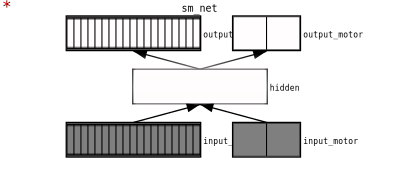

In [16]:
sm_net = build_lower_net("sm_net", num_hiddens=25, num_inputs=21)
sm_net.picture()

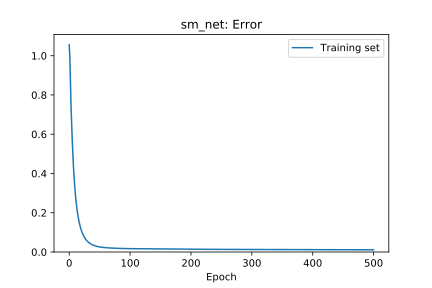

In [7]:
training_set1 = make_sm_net_dataset(data, recall_steps)
sm_history = train(sm_net, training_set1, sm_epochs)
sm_net.save_weights() 

In [18]:
training_set2 = make_hidden_net_dataset(data, recall_steps, sm_net)
hid_net = build_hidden_net("hid_net", num_hiddens=50, num_inputs=50)
hid_net.picture()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_hidden (InputLayer)       (None, 25)           0                                            
__________________________________________________________________________________________________
input_goal (InputLayer)         (None, 25)           0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 50)           0           input_hidden[0][0]               
                                                                 input_goal[0][0]                 
__________________________________________________________________________________________________
hidden (Dense)                  (None, 50)           2550        concatenate_9[0][0]              
__________

<IPython.core.display.Javascript object>

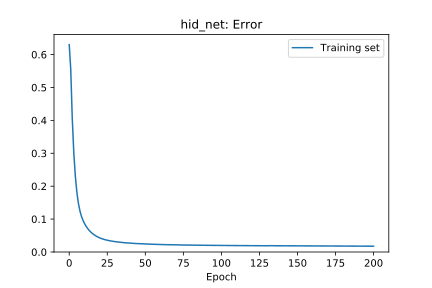

In [8]:
hid_history = train(hid_net, training_set2, hid_epochs)
hid_net.save_weights()

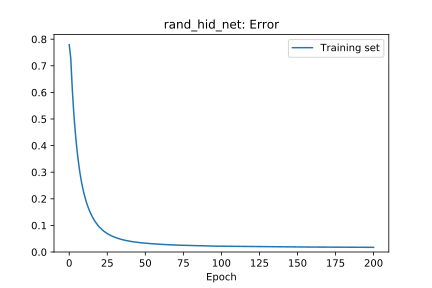

In [9]:
rand_training_set2 = make_hidden_net_dataset(data, recall_steps, sm_net, random_goals=True)
save_random_hidden_net_dataset("%s/random_hidden_net.training_set" % dirname, rand_training_set2)
rand_hid_net = build_hidden_net("rand_hid_net", num_hiddens=50, num_inputs=50)
rand_hid_history = train(rand_hid_net, rand_training_set2, hid_epochs)
rand_hid_net.save_weights() 

* data["step"] is move/sense/pose at each step:
  * data["step"][n]["move"] is (translate, rotate)
  * data["step"][n]["pose"] is (x, y, angle)
  * data["step"][n]["sense"] is (stall, lights, scaled_sonars)
* data["match"] is (min_index, step, interest) for each match
* data["goal"] is (goal_num, step, interest, description) for each goal

## Test Data

In [10]:
def verify(data, recall_steps):
    sim = make_sim()
    robot = sim.robots[0]
    for data_goal in data["goal"]: # for each step goal created
        (goal_num, step, interest, description) = data_goal
        input_g = data["step"][step + 1]["sense"] # (stall, lights, scaled_sonars)
        pose = data["step"][step + 1]["pose"] # (x, y, angle)
        robot.setPose(*pose)
        robot.stall = data["step"][step + 1]["sense"][0]
        sensors = read_sensors(sim)
        if list(input_g) != list(sensors):
            print("goal wrong!", input_g, sensors)
        pose = data["step"][step - recall_steps]["pose"]
        robot.setPose(*pose)
        robot.stall = data["step"][step - recall_steps]["sense"][0]
        sensors = read_sensors(sim)
        input_s = data["step"][step - recall_steps]['sense']
        if list(input_s) != list(sensors):
            print("initial sense wrong!")
            print(input_s)
            print(sensors)
        for j in range(-recall_steps, 1, 1):
            input_s = data["step"][step + j + 1]['sense']
            target_m = data["step"][step + j]['move']
            # make move
            t, r = target_m
            robot.move(t, r)
            sim.step()
            new_pose = robot.getPose()
            if list(new_pose) != data["step"][step + j + 1]['pose']:
                print("step %d pose wrong!" % j)
                print(new_pose)
                print(data["step"][step + j + 1]['pose'])
            sensors = read_sensors(sim)
            if list(input_s) != list(sensors):
                print("step %d wrong!" % j, (t, r))
                print(input_s)
                print(sensors)
        if list(input_s) != list(input_g):
            print("final goal wrong!")
            print(input_s)
            print(input_g)

def test_sensor_network(data, hid_dataset, sensor_dataset, sm_net, hid_size, recall_steps):
    hiddens = [x[0][0] for x in hid_dataset]
    sm_targets = [x[1] for x in sensor_dataset]
    for goal_num in range(len(data["goal"])): # for each goal
        for step in range(recall_steps): # for each step
            output = sm_net.propagate_from("hidden", hiddens[goal_num * (recall_steps) + step])
            print(goal_num, step, sm_targets[goal_num * (recall_steps + 1) + step][1], output[1])

def render_step_behavior(data, start, stop):
    sim = make_sim()
    robot = sim.robots[0]
    canvas = Canvas((400, 400))
    robot.display["robots"] = 0
    robot.display["devices"] = 0
    robot.updateDevices()
    sim.draw(canvas)
    px, py = None, None
    for s in range(start, stop): # goal final state is +1
        pose = data["step"][s]["pose"]
        stall = data["step"][s]["sense"][0]
        robot.setPose(*pose)
        robot.stall = stall
        if px:
            canvas.drawLine(robot._gx, robot._gy, px, py)
        px, py = robot._gx, robot._gy
    canvas.drawArrow(robot._gx, robot._gy, robot._ga, size=0.1)
    return canvas

def distance(x, y):
    squared_diffs = [(np.array(x[i]) - np.array(y[i]))**2 for i in range(len(x))]
    return sum(squared_diffs)

def test_system(data, sm_net, hid_net, recall_steps, hid_dataset,
                sm_dataset, hidden_size, goals=[], render=False, random_goals=False):
    if len(goals) == 0:
        goals = range(len(data["goal"]))
    sim = make_sim()
    robot = sim.robots[0]
    dist_dict = {'end_state': 0, 'motor': 0, 'sensor': 0, 'goal': 0, 'hid': 0}
    dirname = "results_%d" % (set_num)
    if not os.path.exists("%s/pics" % (dirname)):
        os.mkdir("%s/pics" % (dirname))
    for item in [data["goal"][goal] for goal in goals]: # for each step goal created
        (goal_num, step, interest, description) = item
        if render:
            canvas = Canvas((400, 400))
            robot.display["robots"] = 0
            robot.display["devices"] = 0
            robot.updateDevices()
            sim.draw(canvas)
        else:
            canvas = None
        pose = data["step"][step - recall_steps + 2]["pose"]
        stall = data["step"][step - recall_steps + 2]["sense"][0]
        pp_name = "Random protoplans" if random_goals else "Hidden protoplans" ## protoplan type: random or from hidden space
        print("Goal", goal_num, pp_name)
        goal_dict = test_goal(canvas, dirname, sim, robot, data, goal_num, step,
                              sm_net, hid_net, recall_steps, hid_dataset,
                              sm_dataset, hidden_size, goals, render, random_goals, pose, stall,
                              check=True, color="black")
        for key in goal_dict:
            dist_dict[key] += goal_dict[key]
    return dist_dict

def test_goal(canvas, dirname, sim, robot, data, goal_num, step,
              sm_net, hid_net, recall_steps, hid_dataset,
              sm_dataset, hidden_size, goals, render, random_goals, pose, stall,
              check, color):
    if not os.path.exists("%s/pics" % (dirname)):
        os.mkdir("%s/pics" % (dirname))
    sm_step = recall_steps + 1
    end_state_dist = 0
    motor_dist = 0
    sensor_dist = 0
    goal_dist = 0
    hid_dist = 0
    hidden_goal = hid_dataset[goal_num * recall_steps][0][1]
    # put robot at initial pose:
    robot.setPose(*pose)
    robot.stall = stall
    # get sensors:
    sensor_t0 = read_sensors(sim)
    # get hidden_t0:
    motor_t0 = [0.0, 0.0]
    inputs = [sensor_t0, motor_t0]
    hidden = sm_net.propagate_to("hidden", inputs)
    h1 = hid_net.propagate([hidden, hidden_goal])[0]
    if check and list(hidden_goal) != list(hid_dataset[goal_num * recall_steps][0][1]):
        print(goal_num, "hidden_goal is wrong!")
        print(hidden_goal)
        print(hid_dataset[goal_num * recall_steps][0][1])
        return
    if check and list(hidden) != list(hid_dataset[goal_num * recall_steps][0][0]):
        print(goal_num, "initial hidden wrong!")
        print(hidden)
        print(hid_dataset[goal_num * recall_steps][0][0])
        return
    px, py = robot._gx, robot._gy
    for i in range(recall_steps):
        output = sm_net.propagate_from("hidden", h1)
        motor_output = output[1]
        sensor_output = output[0]
        if i == 0:
            # don't really move, that should be no-op
            motor_output = [0.0, 0.0]
        #print(goal_num, i, sm_dataset[goal_num * sm_step + i][0][1], motor_output)
        motor_dist += distance(sm_dataset[goal_num * sm_step + i][0][1], motor_output)
        sensor_dist += distance(sm_dataset[goal_num * sm_step + i][0][0], sensor_output)
        robot.move(*motor_output)
        sim.step()
        if render:
            canvas.drawLine(robot._gx, robot._gy, px, py, outline=color)
        px, py = robot._gx, robot._gy
        sensor_t0 = read_sensors(sim)
        inputs = [sensor_t0, motor_output]
        hidden = sm_net.propagate_to("hidden", inputs)
        hid_net_output = hid_net.propagate([hidden, hidden_goal])
        h1 = hid_net_output[0]
        goal_out = hid_net_output[1]
        hid_dist += distance(hid_dataset[goal_num*recall_steps+i][1][0] , h1)
        goal_dist += distance(hid_dataset[goal_num*recall_steps+i][1][1] , goal_out)
        #if check:
        #    print(goal_num, i, "motor:", sm_dataset[goal_num * sm_step + i][0][1], motor_output, motor_dist)
    end_state_dist += distance(data["step"][step+1]['sense'], read_sensors(sim))
    if render:
        canvas.drawArrow(robot._gx, robot._gy, robot._ga, size=0.1, fill=color, outline=color)
        pp_type = "random_" if random_goals else "" ## protoplan type: random or from hidden space
        canvas.save("%s/pics/%sgenerated_goal_%d.svg" % (dirname, pp_type, goal_num))
        if not random_goals:
            training_canvas = render_step_behavior(data, step - 8, step + 2)
            training_canvas.save("%s/pics/trained_goal_%d.svg" % (dirname, goal_num))
    return {'end_state': end_state_dist, 'motor': motor_dist, 'sensor': sensor_dist, 'goal': goal_dist, 'hid': hid_dist}

def visualize(data, dirname, recall_steps, goals=[]):
    sim = make_sim()
    robot = sim.robots[0]
    canvas = Canvas((400, 400))
    robot.display["robots"] = 0
    robot.display["devices"] = 0
    robot.updateDevices()
    sim.draw(canvas) # sets scale and dimensions
    draw_goals(data, canvas, robot, recall_steps, goals)
    if len(goals) == 0:
        canvas.save("%s/all_goals.svg" % (dirname))
    else:
        canvas.save("%s/select_goals.svg" % (dirname))
    #canvas = render_step_behavior(data, 0, len(data["step"]))
    #canvas.save("behavior.svg")

def draw_goals(data, canvas, robot, recall_steps, goals=[]):
    if len(goals) == 0:
        goals = range(len(data["goal"]))
    for item in [data["goal"][goal] for goal in goals]: # for each step goal created
        (goal_num, step, interest, description) = item
        #pose = data["step"][step]["pose"]
        #stall = data["step"][step]["sense"][0]
        #canvas.drawArrow(pose[0], pose[1], pose[2], size=0.1)
        px, py = None, None
        start = step - recall_steps + 2
        stop = step + 1
        for s in range(start, stop): # goal final state is +1
            pose = data["step"][s]["pose"]
            robot.setPose(*pose)
            if px:
                canvas.drawLine(robot._gx, robot._gy, px, py)
            px, py = robot._gx, robot._gy
        canvas.drawArrow(robot._gx, robot._gy, robot._ga, size=0.1)
    return

def goal_trajectories(data, set_num, recall_steps, random_goals,
                      sm_net, hid_net, hid_dataset,
                      sm_dataset, hidden_size, goals=[]):
    """Use model in generative mode, placing the robot in a variety of situations. Plot
    the trajectories taken."""
    if len(goals) == 0:
        goals = range(len(data["goal"]))
    dirname = "results_%d" % (set_num)
    if not os.path.exists("%s/pics" % (dirname)):
        os.mkdir("%s/pics" % (dirname))
    print("Plotting grid trajectories")
    pp_name = "Random protoplans" if random_goals else "Hidden protoplans" ## protoplan type: random or from hidden space
    for item in [data["goal"][goal] for goal in goals]: # for each step goal created
        (goal_num, step, interest, description) = item
        print("goal %d" % goal_num)
        for angle in np.arange(0,2*math.pi, math.pi/2):
            print("Goal", goal_num, pp_name, angle)
            canvas = Canvas((400, 400))
            sim = make_sim()
            robot = sim.robots[0]
            robot.display["robots"] = 0
            robot.display["devices"] = 0
            robot.updateDevices()
            sim.draw(canvas)
            poses = generate_poses(0.75, 0.75, angle)
            for pose in poses:
                stall = 0
                test_goal(canvas, dirname, sim, robot, data, goal_num, step,
                          sm_net, hid_net, recall_steps, hid_dataset,
                          sm_dataset, hidden_size, goals, render, random_goals, pose, stall,
                          check=False, color="black")
            # # see the trained goal trajectory on every picture:
            # pose = data["step"][step - recall_steps + 2]["pose"]
            # stall = False
            # test_goal(canvas, dirname, sim, robot, data, goal_num, step,
            #           sm_net, hid_net, recall_steps, hid_dataset,
            #           sm_dataset, hidden_size, goals, render, random_goals, pose, stall,
            #           check=True, color="red")
            if random_goals:
                canvas.save("%s/pics/rand_%s.svg" % (dirname, "goal_%d_angle%s" % (goal_num, ("%.1f" % angle).replace(".", "_"))))
            else:
                canvas.save("%s/pics/%s.svg" % (dirname, "goal_%d_angle%s" % (goal_num, ("%.1f" % angle).replace(".", "_"))))

def generate_poses(x_diff, y_diff, heading):
    """Return a list of poses with a fixed heading, that change by increments of x_diff and y_diff"""
    robot_width = 0.5
    sim_height = 4
    sim_width = 4
    x = np.arange(robot_width, sim_width+0.1-robot_width, x_diff)
    y = np.arange(robot_width, sim_height+0.1-robot_width, y_diff)
    poses = []
    for i in range(len(x)):
        for j in range(len(y)):
            poses.append((x[i], y[j], heading))
    return poses

def report_distances(fp, dict, rand_dict, num_goals):
    for key in dict:
        print("Hidden", "%10s" % key, dict[key]/num_goals, file=fp)
        print("Random", "%10s" % key, rand_dict[key]/num_goals, file=fp)
        print(file=fp)

def restore_random_hidden_net_dataset(filename):
    return pickle.load(open(filename, "rb"))

def plot_goal_memory_growth(data, dirname):
    # Plot the growth of the goal memory
    # data["goal"] is (goal_num, step, interest, description) for each goal
    print("Plotting goal memory growth to", dirname)
    goals = {step for (goal_num, step, interest, description) in data["goal"]}
    track_memory_size = []
    size = 0
    for step in range(len(data["step"])):
        if step in goals:
            size += 1
        track_memory_size.append(size)
    plt.figure(1)
    plt.subplot(1,1,1)
    plt.plot(np.arange(len(track_memory_size)), track_memory_size, 'c-')
    plt.title("Goal creation")
    plt.xlabel("Step")
    plt.ylabel("Number of goals")
    plt.savefig("%s/goal_memory.png" % dirname)
    plt.close('all')

def goal_space_cluster(data, dirname, hid_dataset, recall_steps, hidden_size,
                       title, top=100, include=[]):
    """Generate a cluster diagram of the discovered goals."""
    print("\nGenerating cluster diagram of the goal representations \n")
    from scipy.cluster import hierarchy
    from scipy.spatial import distance
    # Build the goal_memory data structure:
    goal_memory = []
    for (goal_num, step, interest, description) in data["goal"]:
        goal_memory.append({
            "goal_num": goal_num,
            "matched": 1 if goal_num not in include else 1000, # HACK to include special
            "goal": hid_dataset[goal_num * recall_steps][0][1]
        })
    for (goal_num, step, interest) in data["match"]:
        goal_memory[goal_num]["matched"] += 1
    # Get the most popular ones:
    sorted_goals = sorted(goal_memory, key=lambda goal: goal["matched"])
    goal_reps = [goal["goal"] for goal in sorted_goals[-top:]]
    labels = [goal["goal_num"] for goal in sorted_goals[-top:]]
    orig_figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (13, 5)
    linkage = hierarchy.linkage(goal_reps, method="single")
    threshold = 0.3
    clusters = hierarchy.fcluster(linkage, threshold, criterion="distance")
    hierarchy.dendrogram(linkage, color_threshold=0.01, labels=labels)
    plt.title(title)
    plt.xlabel("Goal")
    plt.ylabel("Distance")
    plt.savefig("%s/%s.png" % (dirname, title))
    plt.close('all')
    plt.rcParams["figure.figsize"] = orig_figsize

def plot_trace(data, dirname, start, stop, name):
    """Helper for plot_all_traces: plots one set of subplots for steps
    from start to stop with the given name"""
    labelsize = 6
    x = np.arange(start, stop)
    goalset = {step for (goal_num, step, interest, description) in data["goal"]}
    goals = [(1.75 if step in goalset else 0.0) for step in range(start, stop)]
    matchset = {step for (goal_num, step, interest) in data["match"]}
    matches = [(1.75 if step in matchset else 0.0) for step in range(start, stop)]
    plt.figure(1)
    axis = plt.subplot(1,1,1)
    plt.ylim((0,1.75))
    plt.plot(x, goals, "b-")
    plt.plot(x, matches, "r-")
    plt.plot(x, [d["interest"] for d in data["step"][start:stop]], 'k-')
    plt.ylabel("Interest")
    plt.xlabel("Step")
    axis.tick_params(labelsize=labelsize)
    plt.savefig("%s/%s.png" % (dirname, name))
    plt.clf()
    plt.cla()
    plt.close('all')

In [11]:
recall_steps = 10
render = True
set_num = 0
goals = []
dirname = "results_%d" % (set_num)
data = read_data(dirname, set_num)

Reading experiment #0 data files...
Read 1000 data lines
Read 1000 pose lines
Read 38 goal lines
Read 38 pose lines
   steps   : 1000
   matches : 19
   goals   : 19


In [12]:
sm_net = build_lower_net("sm_net", num_hiddens=25, num_inputs=21)
sm_net.load_weights()

hid_net = build_hidden_net("hid_net", num_hiddens=50, num_inputs=50)
hid_net.load_weights()

rand_hid_net = build_hidden_net("rand_hid_net", num_hiddens=50, num_inputs=50)
rand_hid_net.load_weights()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sensor (InputLayer)       (None, 19)           0                                            
__________________________________________________________________________________________________
input_motor (InputLayer)        (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 21)           0           input_sensor[0][0]               
                                                                 input_motor[0][0]                
__________________________________________________________________________________________________
hidden (Dense)                  (None, 25)           550         concatenate_4[0][0]              
__________

In [13]:
training_set1 = make_sm_net_dataset(data, recall_steps)
training_set2 = make_hidden_net_dataset(data, recall_steps, sm_net)
rand_training_set2 = restore_random_hidden_net_dataset("%s/random_hidden_net.training_set" % dirname)

In [14]:
#plot_trace(data, dirname, 0, 250, "interest_plot")
plot_goal_memory_growth(data, dirname)
goal_space_cluster(data, dirname, training_set2, recall_steps, 25,
                   "Abstract Protoplan Representation Cluster", top=50, include=[24, 110])
goal_space_cluster(data, dirname, rand_training_set2, recall_steps, 25,
                   "Random Protoplan Representation Cluster", top=50, include=[24, 110])
visualize(data, dirname, recall_steps, goals)
goal_trajectories(data, set_num, recall_steps, False, # random_goals
                  sm_net, hid_net, training_set2,
                  training_set1, 25, goals=goals)
goal_trajectories(data, set_num, recall_steps, True, # random_goals
                  sm_net, rand_hid_net, rand_training_set2,
                  training_set1, 25, goals=goals)

Plotting goal memory growth to results_0

Generating cluster diagram of the goal representations 



/home/dblank/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))



Generating cluster diagram of the goal representations 

Plotting grid trajectories
goal 0
Goal 0 Hidden protoplans 0.0
Goal 0 Hidden protoplans 1.5707963267948966
Goal 0 Hidden protoplans 3.141592653589793
Goal 0 Hidden protoplans 4.71238898038469
goal 1
Goal 1 Hidden protoplans 0.0
Goal 1 Hidden protoplans 1.5707963267948966
Goal 1 Hidden protoplans 3.141592653589793
Goal 1 Hidden protoplans 4.71238898038469
goal 2
Goal 2 Hidden protoplans 0.0
Goal 2 Hidden protoplans 1.5707963267948966
Goal 2 Hidden protoplans 3.141592653589793
Goal 2 Hidden protoplans 4.71238898038469
goal 3
Goal 3 Hidden protoplans 0.0
Goal 3 Hidden protoplans 1.5707963267948966
Goal 3 Hidden protoplans 3.141592653589793
Goal 3 Hidden protoplans 4.71238898038469
goal 4
Goal 4 Hidden protoplans 0.0
Goal 4 Hidden protoplans 1.5707963267948966
Goal 4 Hidden protoplans 3.141592653589793
Goal 4 Hidden protoplans 4.71238898038469
goal 5
Goal 5 Hidden protoplans 0.0
Goal 5 Hidden protoplans 1.5707963267948966
Goal 5 Hid

In [15]:
if goals == []:
    with open("%s/distance.txt" % dirname, "w") as fp:
        dist_dict = test_system(data, sm_net, hid_net, recall_steps, training_set2,
                                training_set1, 25, render=render, random_goals=False, goals=goals)
        rand_dist_dict = test_system(data, sm_net, rand_hid_net, recall_steps, rand_training_set2,
                                     training_set1, 25, render=render, random_goals=True, goals=goals)
        report_distances(fp, dist_dict, rand_dist_dict, len(data["goal"]))

Goal 0 Hidden protoplans
Goal 1 Hidden protoplans
Goal 2 Hidden protoplans
Goal 3 Hidden protoplans
Goal 4 Hidden protoplans
Goal 5 Hidden protoplans
Goal 6 Hidden protoplans
Goal 7 Hidden protoplans
Goal 8 Hidden protoplans
Goal 9 Hidden protoplans
Goal 10 Hidden protoplans
Goal 11 Hidden protoplans
Goal 12 Hidden protoplans
Goal 13 Hidden protoplans
Goal 14 Hidden protoplans
Goal 15 Hidden protoplans
Goal 16 Hidden protoplans
Goal 17 Hidden protoplans
Goal 18 Hidden protoplans
Goal 0 Random protoplans
Goal 1 Random protoplans
Goal 2 Random protoplans
Goal 3 Random protoplans
Goal 4 Random protoplans
Goal 5 Random protoplans
Goal 6 Random protoplans
Goal 7 Random protoplans
Goal 8 Random protoplans
Goal 9 Random protoplans
Goal 10 Random protoplans
Goal 11 Random protoplans
Goal 12 Random protoplans
Goal 13 Random protoplans
Goal 14 Random protoplans
Goal 15 Random protoplans
Goal 16 Random protoplans
Goal 17 Random protoplans
Goal 18 Random protoplans
